In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split, GridSearchCV, KFold  
from data_generation import m_0, g_0, get_data

## Fix one dataset

In [2]:
np.random.seed(seed=123)
N = 300
y_data, d_data, x_data = get_data(N)
print(f'Percentage of treated units: {np.mean(d_data)}')

Percentage of treated units: 0.5633333333333334


In [3]:
y_train, y_eval, d_train, d_eval, x_train, x_eval = train_test_split(y_data, d_data, x_data, test_size=0.2, random_state=42)

## Tune ML estimators for this dataset / sample size

In [4]:
model_g0 = lgb.LGBMRegressor(colsample_bytree=1.0, learning_rate=0.3, reg_lambda=10, max_depth=3, n_estimators=10, subsample=0.7, verbosity=0)
model_g1 = lgb.LGBMRegressor(colsample_bytree=1.0, learning_rate=0.1, reg_lambda=1, max_depth=3, n_estimators=50, subsample=0.7, verbosity=0)
model_g = [model_g0, model_g1]
model_m = lgb.LGBMClassifier(colsample_bytree=0.7, learning_rate=0.1, reg_lambda=1, max_depth=3, n_estimators=50, subsample=0.85, verbosity=0)

In [5]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist')

param_grid = {
    'n_estimators': [5, 10, 25, 50, 100],
    'max_depth': [3, 5, 7],
    #'subsample': [0.7, 0.85, 1.0],
    #'colsample_bytree': [0.7, 0.85, 1.0],
    #'eta': [0.1, 0.2, 0.3],
    #'lambda': [0.1, 1, 10] 
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5)

### For $g_0(1,X)=E[Y|D=1,X]$:

In [6]:
grid_search.fit(x_data[d_data==1], y_data[d_data==1])
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
model_g1 = grid_search.best_estimator_

Best Hyperparameters: {'max_depth': 5, 'n_estimators': 10}
Best Score: 0.6576660056712572


In [7]:
model_g1.fit(X=x_train[d_train==1], y=y_train[d_train==1])
print(f'Training error: {np.mean(np.abs(model_g1.predict(x_train) - g_0(1, x_train)))}')
print(f'Evaluation error: {np.mean(np.abs(model_g1.predict(x_eval) - g_0(1, x_eval)))}')

Training error: 0.30215775968137104
Evaluation error: 0.24724897330573997


### For $g_0(0,\cdot)=E[Y|D=0,X]$:

In [8]:
grid_search.fit(x_data[d_data==0], y_data[d_data==0])
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
model_g0 = grid_search.best_estimator_

Best Hyperparameters: {'max_depth': 3, 'n_estimators': 5}
Best Score: 0.36223290222009413


In [9]:
model_g0.fit(X=x_train[d_train==0], y=y_train[d_train==0])
print(f'Training error: {np.mean(np.abs(model_g0.predict(x_train) - g_0(0, x_train)))}')
print(f'Evaluation error: {np.mean(np.abs(model_g0.predict(x_eval) - g_0(0, x_eval)))}')

Training error: 0.20458733583781902
Evaluation error: 0.20852080849859578


In [10]:
model_g = [model_g0, model_g1]

### For $m_0(X)=E[D|X]$:

In [23]:
xgb_model = xgb.XGBRegressor(objective='reg:logistic', tree_method='hist')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5)
grid_search.fit(x_data, d_data)
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
model_m = grid_search.best_estimator_

Best Hyperparameters: {'max_depth': 3, 'n_estimators': 10}
Best Score: 0.15563932277400058


In [24]:
model_m.fit(X=x_train, y=d_train)
print(f'Training error: {np.mean(np.abs(model_m.predict(x_train) - m_0(x_train)))}')
print(f'Evaluation error: {np.mean(np.abs(model_m.predict(x_eval) - m_0(x_eval)))}')

Training error: 0.10345861513710236
Evaluation error: 0.10104889683828129


In [13]:
xgb_model = xgb.XGBClassifier(tree_method='hist')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5)
grid_search.fit(x_data, d_data)
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
model_m = grid_search.best_estimator_

Best Hyperparameters: {'max_depth': 3, 'n_estimators': 25}
Best Score: 0.7166666666666667


In [14]:
model_m.fit(X=x_train, y=d_train)
print(f'Training error: {np.mean(np.abs(model_m.predict_proba(x_train)[:,1] - m_0(x_train)))}')
print(f'Evaluation error: {np.mean(np.abs(model_m.predict_proba(x_eval)[:,1] - m_0(x_eval)))}')

Training error: 0.14023465839849722
Evaluation error: 0.11925821744734082


In [26]:
model_m.predict(x_eval)[:20]

array([0.21992083, 0.4369014 , 0.8576841 , 0.69002193, 0.8342965 ,
       0.6545499 , 0.6247167 , 0.6866734 , 0.6866734 , 0.65070325,
       0.45014584, 0.8342965 , 0.43947023, 0.2467503 , 0.6866734 ,
       0.6247167 , 0.5948308 , 0.1305712 , 0.6622545 , 0.84729296],
      dtype=float32)

In [21]:
m_0(x_eval)[:20]

array([0.54765592, 0.58564028, 0.90331341, 0.57284588, 0.73066247,
       0.53868859, 0.65386739, 0.59997598, 0.55592707, 0.60882562,
       0.52234801, 0.66285442, 0.15811359, 0.18410725, 0.63477156,
       0.77899483, 0.60085283, 0.30443804, 0.68782526, 0.963082  ])

## Hard-code best ML models to avoid running CV everytime

In [13]:
model_g0 = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', colsample_bytree=1.0, 
                            eta=0.3, reg_lambda=10, max_depth=3, n_estimators=10, subsample=0.7)
model_g1 = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', colsample_bytree=1.0, 
                            eta=0.1, reg_lambda=1, max_depth=3, n_estimators=50, subsample=0.7)
model_g = [model_g0, model_g1]
model_m = xgb.XGBClassifier(tree_method='hist', colsample_bytree=1.0, 
                           eta=0.1, reg_lambda=1, max_depth=3, n_estimators=50, subsample=0.85)

## DML algorithm

In [ ]:
# Neyman orthogonal score
def psi_ate(h_0, h_1, h_2, y, d, x, theta):
    return h_1(x) - h_0(x) + d*(y-h_1(x))/h_2(x) - (1-d)*(y-h_0(x))/(1-h_2(x)) - theta

In [14]:
def dml_reg_ipw_ate(K, y_data, d_data, x_data, model_g, model_m):
    # Generate random partition of data for cross-fitting
    indices = np.arange(N)
    kf = KFold(n_splits=K, shuffle=True)#, random_state=42)

    # Compute respective ML estimators and thereupon auxiliary estimators
    theta_0_check = []
    reg_check, ipw_check = [], []
    for (train_indices, eval_indices) in kf.split(x_data):
        y_train, d_train, x_train = y_data[train_indices], d_data[train_indices], x_data[train_indices]
        y_eval, d_eval, x_eval = y_data[eval_indices], d_data[eval_indices], x_data[eval_indices]

        # Estimate outcome regression functions g_0(d)
        g_0_hat = []
        for d in [0,1]:
            model_g[d].fit(X=x_train[d_train==d], y=y_train[d_train==d])
            g_0_hat.append(model_g[d].predict(x_eval))

        # Estimate propensity score m_0
        model_m.fit(X=x_train, y=d_train)
        m_0_hat = model_m.predict_proba(x_eval)[:,-1]
            
        # Compute auxiliary estimator
        theta_0_check.append(np.mean(g_0_hat[1] - g_0_hat[0] + d_eval*(y_eval-g_0_hat[1])/m_0_hat
                                     - (1-d_eval)*(y_eval-g_0_hat[0])/(1-m_0_hat)))

        # Regression estimator 
        reg_check.append(np.mean(g_0_hat[1] - g_0_hat[0]))
        # IPW estimator
        ipw_check.append(np.mean(d_eval*y_eval/m_0_hat - (1-d_eval)*y_eval/(1-m_0_hat)))

    # Compute final estimators
    theta_0_hat = np.mean(theta_0_check)
    reg_hat, ipw_hat = np.mean(reg_check), np.mean(ipw_check)

    return np.array([theta_0_hat, reg_hat, ipw_hat])

In [15]:
%%time
K = 5
dml_reg_ipw_ate(K, y_data, d_data, x_data, model_g, model_m)

CPU times: total: 1.61 s
Wall time: 489 ms


array([1.00973097, 1.03546429, 1.16381188])

## MC simulation of DML

In [ ]:
theta_0 = 1   # true ATE

In [48]:
%%time
N = 250
n_MC = 50
K = 5
estimates_list = np.empty((n_MC, 3))

for j in range(n_MC):
    y_data, d_data, x_data = get_data(N)
    estimates_list[j] = dml_reg_ipw_ate(K, y_data, d_data, x_data, model_g, model_m)

CPU times: total: 1min 15s
Wall time: 22.7 s


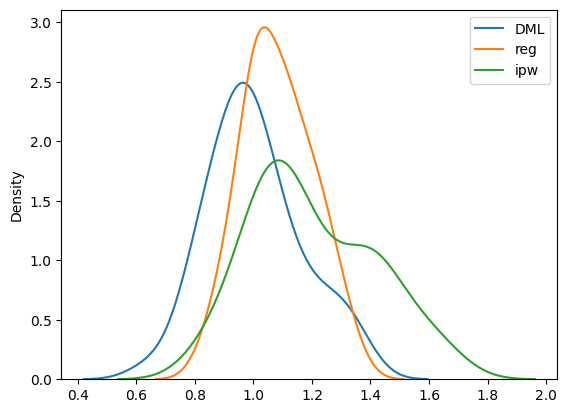

In [49]:
#sns.kdeplot(infeasible_estimates_list, label='infeasible')
sns.kdeplot(estimates_list[:,0], label='DML')
sns.kdeplot(estimates_list[:,1], label='reg')
sns.kdeplot(estimates_list[:,2], label='ipw')
plt.legend()
plt.show()

In [50]:
print(f'Mean of estimates: {np.mean(estimates_list, axis=0)}')
print(f'Standard deviation of estimates: {np.std(estimates_list, axis=0)}')
print(f'MSE estimates: {np.mean((estimates_list-1)**2, axis=0)}')

Mean of estimates: [1.0039349  1.08317362 1.20260827]
Standard deviation of estimates: [0.15973506 0.11883237 0.20900396]
MSE estimates: [0.02553077 0.02103898 0.08473277]
